In [2]:
import SimpleITK as sitk
import itk
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from IPython import display
import pydicom
from pydicom.data import get_testdata_files as view
import argparse
import pydicom as dicom
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import apply_voi_lut
import png

In [3]:


ds = pydicom.dcmread("input.dcm")
if 'WindowWidth' in ds:
    print('Dataset has windowing')

windowed = apply_voi_lut(ds.pixel_array, ds)

shape = ds.pixel_array.shape

# Convert to float to avoid overflow or underflow losses.
image_2d = ds.pixel_array.astype(float)

# Rescaling grey scale between 0-255
image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

# Convert to uint
image_2d_scaled = np.uint8(image_2d_scaled)

# Write the PNG file
with open(f'{"input.dcm".strip(".dcm")}.png', 'wb') as png_file:
    w = png.Writer(shape[1], shape[0], greyscale=True)
    w.write(png_file, image_2d_scaled)

Dataset has windowing


from downloaddata import fetch_data, fetch_data_all


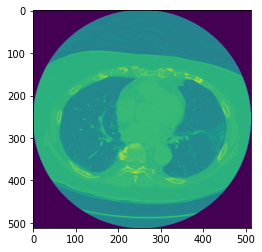

In [4]:
# %env SITK_SHOW_COMMAND /Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP
# image_viewer = sitk.ImageViewer()
image_path = '../DICOM2/1-140.dcm'
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array)

In [5]:
input = "input.png"
output = "output.png"
threshold = float(0.002)
level = float(.2)

Dimension = 2

FloatPixelType = itk.ctype("float")
FloatImageType = itk.Image[FloatPixelType, Dimension]

reader = itk.ImageFileReader[FloatImageType].New()
reader.SetFileName(input)

gradientMagnitude = itk.GradientMagnitudeImageFilter.New(Input=reader.GetOutput())

watershed = itk.WatershedImageFilter.New(Input=gradientMagnitude.GetOutput())

watershed.SetThreshold(threshold)
watershed.SetLevel(level)

LabeledImageType = type(watershed.GetOutput())

PixelType = itk.ctype("unsigned char")
RGBPixelType = itk.RGBPixel[PixelType]
RGBImageType = itk.Image[RGBPixelType, Dimension]

ScalarToRGBColormapFilterType = itk.ScalarToRGBColormapImageFilter[
    LabeledImageType, RGBImageType
]
colormapImageFilter = ScalarToRGBColormapFilterType.New()
colormapImageFilter.SetColormap(
    itk.ScalarToRGBColormapImageFilterEnums.RGBColormapFilter_Jet
)
colormapImageFilter.SetInput(watershed.GetOutput())
colormapImageFilter.Update()

WriterType = itk.ImageFileWriter[RGBImageType]
writer = WriterType.New()
writer.SetFileName(output)
writer.SetInput(colormapImageFilter.GetOutput())
writer.Update()

In [ ]:
%tb
